In [1]:
//%jsroot on

#include <iostream>
#include <fstream>
 
using namespace std;

In [2]:
TCanvas *c1=new TCanvas;
TFile *f=new TFile("liquidpsd.root");

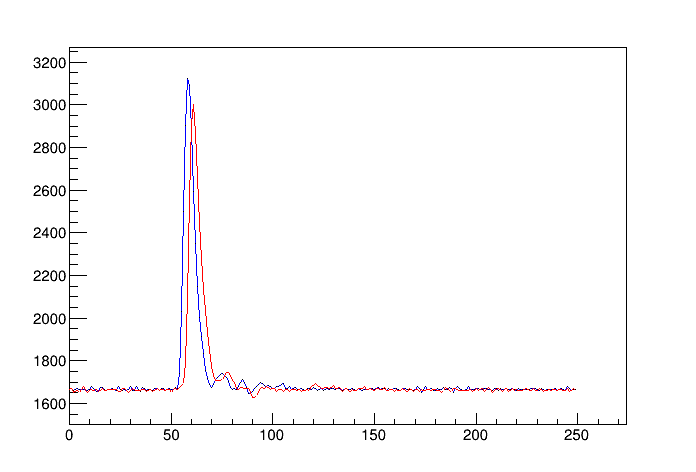

In [3]:
c1->Clear();
g00020->SetLineColor(kBlue);
g00020->Draw();
g00030->SetLineColor(kRed);
g00030->Draw("same");
c1->Draw();

# 对基线修正函数进行定义

In [4]:
void BaseCorrection(int gindex, TGraph *gb, TFile *f)
{
    //从文件指针*f中得到name为“g00020”的TGraph指针，Form()函数用法与c语言中的printf类似;
    TGraph *g=(TGraph*)f->Get(Form("g%05d",gindex));
    double *y=g->GetY();//将TGraph的y轴数值按顺序填入数组y;
    double yb[250];
    double base=0; 
    for(int i=0;i<40;i++) {
        base += y[i];
    }
    base /=40.;
    gb->Clear();
    gb->SetTitle(Form("gindex=%d",gindex));
    for(int i=0;i<250;i++) {
        yb[i]=y[i]-base;
        gb->SetPoint(i,i,yb[i]);
    } 
}

# 对时间修正函数进行定义
询问老师得知，题目中的时间修正函数写错了，于是我自己重新改写该函数，主要思路如下：
- 求得原波形最高值点与59的差值
- 在循环中如果x+dx小于0，将其添加至新波形末尾;如果x+dx超过249，则将其添加至新波形开始。简单来讲就是：将左移的波形失去的一块补到末尾，将右移波形多出来的一块添加到开头，因为tail的积分对于分辨有所帮助，而无论其位置在哪，积分总是相同
- 对于没有超界的值来讲，将x+dx和y值填入新的graph


<font size = 4>可以看到，这样修正完的波形其最高点均在59，且数据没有任何遗失

In [5]:
void TimeCorrection(TGraph *gb, TGraph *gc){

    gc->Clear();
    double *y = gb->GetY();
    int xmax = TMath::LocMax(250, y);
    int dx = 59 - xmax;

    for(int i = 0; i < 250; i++ ){
        double x, y;
        gb->GetPoint(i, x, y);
        if(x + dx < 0) {
            x = 250 - i;
            gc->SetPoint(x, x, y);
        }
        if(x + dx >= 250) {
            x = x + dx -(i+1);
            gc->SetPoint(x, x, y);
        }
        else gc->SetPoint(x+dx, x+dx, y);
    }
}

In [6]:
auto *base = new TGraph;
auto *time_gra = new TGraph;
BaseCorrection(20, base, f);
TimeCorrection(base, time_gra);


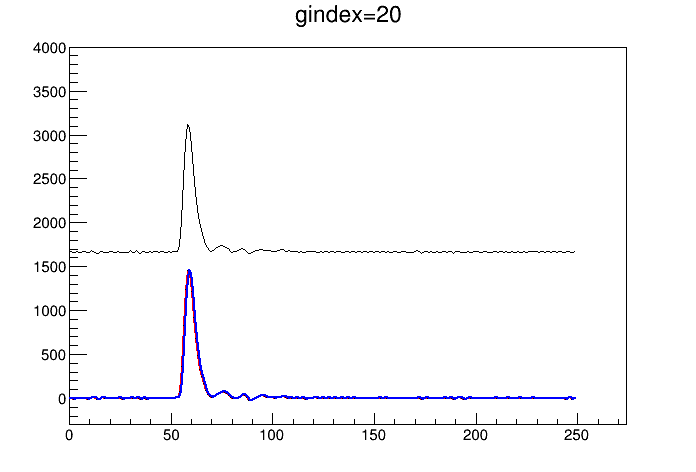

In [7]:
c1->Clear();
base->SetLineColor(kRed);
base->SetMaximum(4000);
base->SetMinimum(-300);
base->Draw();
time_gra->SetLineColor(kBlue);
time_gra->SetLineWidth(2);
time_gra->Draw("same");
g00020->SetLineColor(kBlack);
g00020->Draw("same");
c1->Draw();

# 定义拟合函数

In [8]:
double Fit(TH1F *g, double height, double middle, double right, double left, int choose){
    TF1 *fit = new TF1("fit", "[0]*exp(-((x-[1])/[2])*((x-[1])/[2]))");//定义高斯函数
    fit->SetParameter(0, height);//参数初始化
    fit->SetParameter(1, middle);
    fit->SetParameter(2, 0.05);

    g->Fit("fit", " ", " ", right, left);

    double m = fit->GetParameter(1);
    double delta = fit->GetParameter(2);

    if(choose == 0) return m;//返回中心值
    else if (choose == 1) return delta;//返回delta值
    else {
        cout << "change choose to 0 or 1" << endl;
        return 0;
    }
}


# 定义主函数
主函数的功能可分为几点：
- 对tail total fast psd进行求值，并将其填入新生成的root文件，以备后续使用；
- 对psd：total，tail：total绘制二维对比图，由此观察中子、光子各自波形的条件；
- 绘制psd图，由此判断分辨的好坏；
- 对1000个中子的波形求平均，对1000个光子的波形求平均，然后对其做差，然后由差值的形状寻找最优积分区间；
- 计算FoM值；


In [9]:
void psd_file(){

    TFile *input = new TFile("liquidpsd.root", "READ"); // 读入数据文件

    double tail, fast, total, psd;
    TFile *output = new TFile("output.root", "RECREATE"); //创建新文件，存储数据方便未来使用
    TTree *tree = new TTree("tree", "correction");

    tree->Branch("tail", &tail, "tail/D");
    tree->Branch("fast", &fast, "fast/D");
    tree->Branch("total", &total, "total/D");
    tree->Branch("psd", &psd, "psd/D");

    int t0=50;//fast，total门的左边界
    int t1=70;//fast的右边界
    int t2=250;//total的右边界
    int count1 = 0;
    int count2 = 0;
    double y_n[250] = {0}, y_g[250] = {0}; //初始化两个数组，在取平均时使用
    double inte1, inte2;

    auto *gra_neutron = new TGraph;
    auto *gra_gamma = new TGraph;
    auto *gra_minus = new TGraph;

    ofstream dataFile;//设置log文件，记录运行中产生的数据，方便查阅
    dataFile.open("dataFile.txt");
  
    for(int j = 0; j < 10000; j++){

        tail = 0, fast = 0, total = 0, psd = 0;

        //TGraph *gra_tem = (TGraph*)input->Get(Form("g%0d", j-1));
        auto *gra_baseline_corre = new TGraph;
        auto *gra_time_corre = new TGraph;
        BaseCorrection(j, gra_baseline_corre, input); //利用基线校准函数校准
        TimeCorrection(gra_baseline_corre, gra_time_corre); //利用时间校准函数进行校准

        double *y = gra_time_corre->GetY();

        for(int i=t0;i<t1;i++) fast += y[i];
        for(int i=t0;i<t2;i++) total += y[i];

        tail = total - fast;//对变量求值
        psd = tail/total;

        tree->Fill();
        
        if (psd > 0.3 && total >20000) {//由图判断出的中子波形条件

            count1 += 1;
            if (count1 > 1000) break; //数值超出1000，自动中断
            else {
                inte1 = gra_time_corre->Integral();
                double *neu = gra_time_corre->GetY();
                for(int i_n = 0; i_n < 250; i_n++){
                    y_n[i_n] += neu[i_n]/inte1; //将1000个归一化波形的y值填入数组
                }
        }
        }
        
        for(int j_n = 0; j_n < 250; j_n++){
        
            gra_neutron->SetPoint(j_n, j_n, y_n[j_n]/1000); //填充平均后的graph
                }
        

        if (psd < 0.2 && total >20000){//gamma操作同上

            count2 +=1;
            if (count2 > 1000) break;
            else {
                inte2 = gra_time_corre->Integral();
                double *gam = gra_time_corre->GetY();
                for(int i_g = 0; i_g < 250; i_g++){
                    y_g[i_g] += gam[i_g]/inte2;
                }
            }
        }
        
        for(int j_g = 0; j_g < 250; j_g++){
            
            gra_gamma->SetPoint(j_g, j_g, y_g[j_g]/1000);
                }

        dataFile << tail << " " << total << " " << fast << " " << psd << endl;//填入log文件
        
        //gra_baseline_corre->Clear();
        //gra_time_corre->Clear();
    }

    tree->Write();//tree写入
    output->Close();
    dataFile.close();//运行log文件关闭

    TFile *input1 = new TFile("output.root", "READ"); //读入产生的文件
    TTree *new_tree = (TTree*)input1->Get("tree");
    TH1F *h_psd = new TH1F("h_psd", " ", 50, 0, 0.5);

    //tail:total图的绘制
    TCanvas *c = new TCanvas("c", " ", 800, 600);
    new_tree->Draw("tail:total>>h0(1000, 0, 140000, 1000, -10000, 140000)", "tail>-10000 ", "colz");
    c->Draw();
    
    //psd:total图的绘制
    TCanvas *c0 = new TCanvas("c0", " ", 800, 600);
    new_tree->Draw("psd:total>>h1(200, 0, 140000, 100, -0.1, 0.7)", "psd>-1", "colz");
    c0->Draw();

    //psd图的绘制
    TCanvas *c1 = new TCanvas("c1", " ", 800, 600);
    new_tree->Draw("psd>>h_psd");
    
    double mid_gamma = Fit(h_psd, 500, 0.07, 0.05, 0.1, 0);
    double mid_neutron = Fit(h_psd, 200, 0.3, 0.25, 0.35, 0);
    double mid_diff = mid_neutron - mid_gamma;
    double delta_g = Fit(h_psd, 500, 0.07, 0.05, 0.1, 1);
    double delta_n = Fit(h_psd, 200, 0.3, 0.25, 0.35, 1);
    cout << "FoM = " << mid_diff/(2*sqrt(2*log(2))*(delta_g + delta_n)) << endl;//计算FoM值

    c1->Draw();

    for (int i_m = 0; i_m < 250; i_m ++){

        gra_minus->SetPoint(i_m, i_m, -y_n[i_m]/1000 + y_g[i_m]/1000);//平均后graph图进行做差产生新的graph
    }

    //绘制相关graph
    TCanvas *c2 = new TCanvas("c2", " ", 800, 600);
    gra_gamma->SetLineColor(kRed);
    gra_gamma->Draw();
    gra_neutron->SetLineColor(kBlue);
    gra_neutron->Draw("same");
    gra_minus->SetLineColor(kBlack);
    gra_minus->SetLineWidth(3);
    gra_minus->Draw("same");

    //图例
    TLegend *legend = new TLegend(0.8, 0.8, 0.9, 0.9);
    legend->AddEntry(gra_gamma, "Gamma", "l");
    legend->AddEntry(gra_neutron, "Neutron", "l");
    legend->AddEntry(gra_minus, "Diff", "l");
    legend->Draw();

    c2->Draw();
    double *diff_y = gra_minus->GetY();//输出差值graph的最高点与最低点
    int diff_min = TMath::LocMin(250, diff_y);
    int diff_max = TMath::LocMax(250, diff_y);
    cout << "diff_max = " << diff_max << " " << "diff_min =" << diff_min << endl;
}

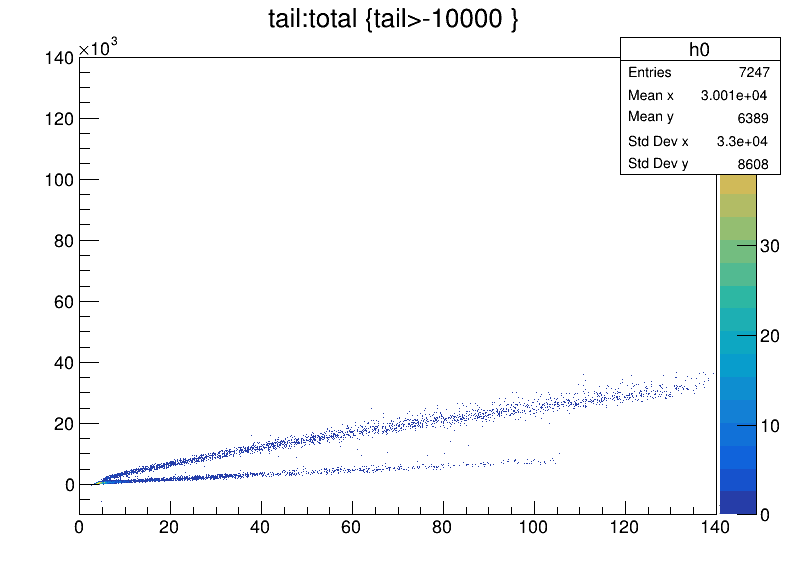

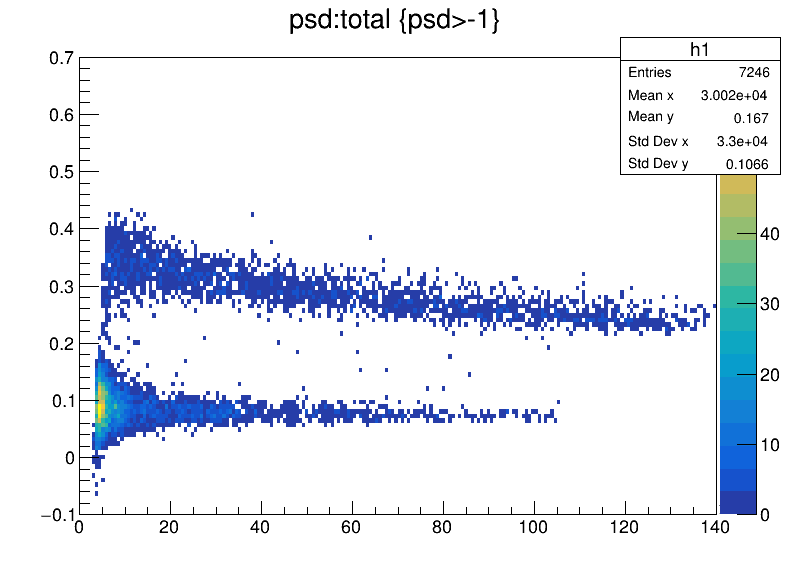

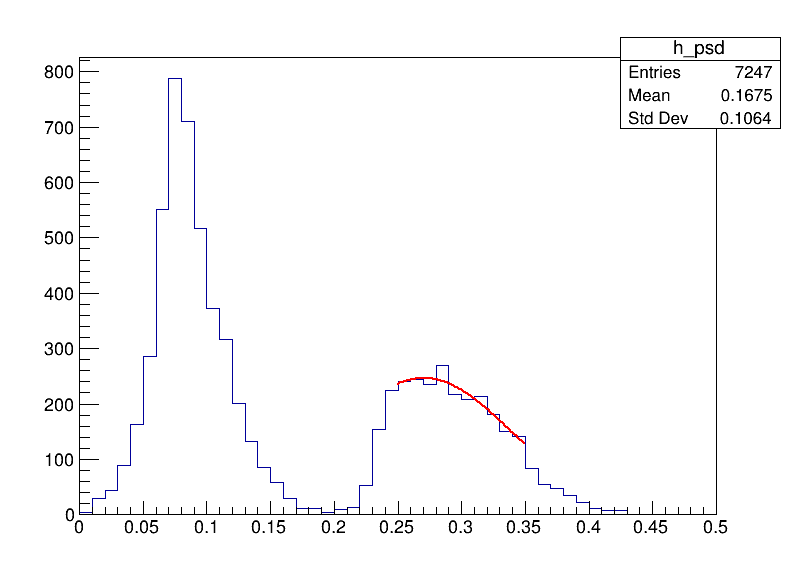

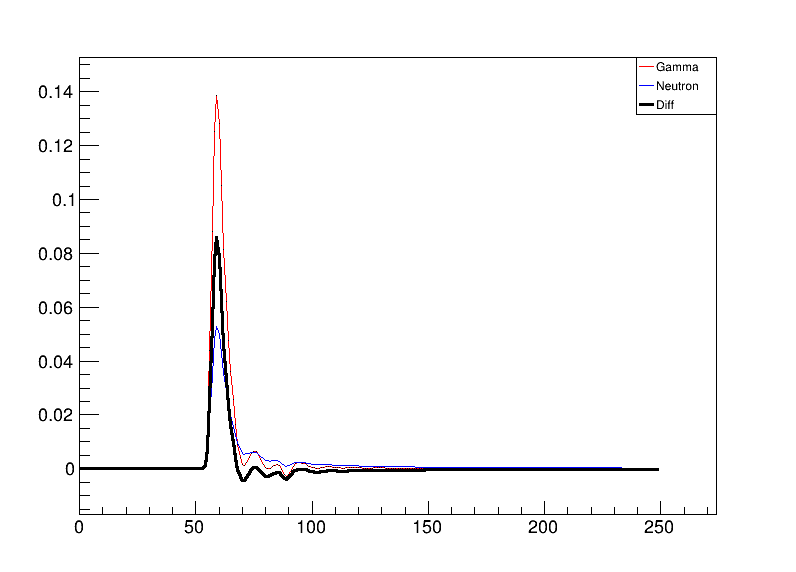

 FCN=82.574 FROM MIGRAD    STATUS=FAILED        101 CALLS         102 TOTAL
                     EDM=3879.73    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.98299e+02   1.27707e+01  -0.00000e+00   2.04024e-01
   2  p1           8.60246e-02   1.00000e+00  -0.00000e+00   5.16075e+03
   3  p2           3.67523e-02   1.00000e+00  -0.00000e+00   3.75331e+03
 FCN=6.52152 FROM MIGRAD    STATUS=CONVERGED     101 CALLS         102 TOTAL
                     EDM=4.40709e-10    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   3.3 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.46348e+02   7.22889e+00  -5.57682e-03   4.27701e-06
   2  p1           2.70556e-01   8.93313e-03   1.26102e-05   1.39412e-02
   3  p2           9.7497

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.


In [10]:
psd_file();

- 选取70的时候得出的FoM为0.583；
- 由图可见，两者的差异基本集中于52至68的范围内，因此最佳积分区间应该选择52-68